![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz,DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import VotingClassifier, BaggingClassifier
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
# Celda 1
def calculate_mse(X_col, y, split):
    left_indices = X_col < split
    right_indices = np.logical_not(left_indices)
    
    left_y = y[left_indices]
    right_y = y[right_indices]
    
    if len(left_y) == 0 or len(right_y) == 0:
        return float('inf')
    
    left_mean = np.mean(left_y)
    right_mean = np.mean(right_y)
    
    # MSE calculation
    mse_left = np.mean((left_y - left_mean) ** 2)
    mse_right = np.mean((right_y - right_mean) ** 2)
    
    mse = mse_left + mse_right 
    mse /= len(y)
    
    return mse

def best_split_mse(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, float('inf')]  # j, split, mse
    
    # Para todas las variables 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            mse = calculate_mse(X.iloc[:, j], y, split)
                        
            if mse < best_split[2]:
                best_split = [j, split, mse]
    
    return best_split

In [6]:
# def tree_grow_mse(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, min_samples_leaf=6):
    
#     # Si solo es una observación
#     if X.shape[0] == 1:
#         tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
#         return tree
    
#     # Calcular la mejor división
#     j, split, gain = best_split_mse(X, y, num_pct)
    
#     # Guardar el árbol y estimar la predicción
#     y_pred = np.mean(y)
    
#     tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
#     # Revisar el criterio de parada 
#     if  gain == float('inf') or gain < min_gain or X.shape[0] <= min_samples_leaf:
#         return tree
    
#     if max_depth is not None and level >= max_depth:
#             return tree   
    
#     # Continuar creando la partición
#     filter_l = X.iloc[:, j] < split
#     X_l, y_l = X.loc[filter_l], y.loc[filter_l]
#     X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    
#     tree['split'] = [j, split]

#     # Siguiente iteración para cada partición
    
#     tree['sl'] = tree_grow_mse(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, min_samples_leaf=min_samples_leaf)
#     tree['sr'] = tree_grow_mse(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, min_samples_leaf=min_samples_leaf)
    
#     return tree

In [7]:
# tree_mse=tree_grow_mse(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10)
# tree_mse

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [8]:
# Celda 2
# Se crea un arreglo de 1 a 20
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 21)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=20, replace=True))

# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = data.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

Arreglo: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Muestreo aleatorio:  [ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


[array([3582, 1346, 5218, ..., 3824, 2046, 2560]),
 array([1999, 4774,  173, ..., 5803,  742, 5039]),
 array([2114, 4003, 3565, ..., 2965,  679, 2539]),
 array([ 6265,  2062,  9901, ...,  8182,  8981, 10457]),
 array([ 1727,  9002, 10082, ...,  9627,  6818,  2533]),
 array([ 9342,  8135,  1731, ..., 10225,  1367,  9054]),
 array([10297,  4474,  4234, ..., 10043,  4228,  5067]),
 array([9836, 9902, 5024, ..., 1281, 3089, 3668]),
 array([ 4266,  6769, 10150, ...,  7107,  7829,  8145]),
 array([6838,   84, 6064, ..., 5539,  847, 9812])]

In [9]:
# Visualización muestra boostrap #1 para entremiento
data.iloc[samples[0], :]

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
137130,8995,2010,88909,False,False,False,False,True,False,False
51669,16500,2015,27217,False,False,False,False,False,True,False
199443,13695,2012,77117,False,True,False,False,False,False,False
292826,19999,2016,35504,False,False,False,False,False,True,False
372365,17302,2017,14738,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
206104,15800,2015,33395,False,False,False,False,True,False,False
160997,17000,2014,28864,False,False,False,False,False,False,True
146432,17295,2016,30214,False,False,False,False,True,False,False
78810,14777,2014,54924,False,False,False,True,False,False,False


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [10]:
# Celda 3


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [11]:
# Celda 4
random_forest = RandomForestClassifier()
random_forest

RandomForestClassifier()

In [12]:
cross_val_score=cross_val_score(random_forest, X_train, y_train, cv=10)


In [13]:
pd.Series(cross_val_score).describe()

count    10.000000
mean      0.021050
std       0.005055
min       0.015647
25%       0.018472
50%       0.019915
75%       0.023471
max       0.032717
dtype: float64

In [14]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
# estimator_range = range(10, 310, 10)

# # Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
# accuracy_scores = []

# # Uso de un 5-fold cross-validation para cada valor de n_estimators
# for estimator in estimator_range:
#     clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
#     accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean())

In [15]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

NameError: name 'estimator_range' is not defined

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 5


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [36]:
# Celda 6
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [39]:
xgb_reg.fit(X_train, y_train)
y_pred=xgb_reg.predict(X_test)

print(f'MSE: {mean_squared_error(y_pred, y_test.values)}, R2 Score: {r2_score(y_pred, y_test.values)}, MAE: {mean_absolute_error(y_pred, y_test.values)}')

MSE: 2576781.074646859, R2 Score: 0.8038713350750613, MAE: 1185.2272991506386


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [45]:
# Celda 7
from sklearn.model_selection import RandomizedSearchCV

# Definir los hiperparámetros a explorar
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

xgb_reg_cal = XGBRegressor()

random_search = RandomizedSearchCV(xgb_reg_cal, param_distributions=param_grid, n_iter=50, scoring='neg_mean_squared_error', cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)


best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)

best_model = random_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


In [46]:
y_pred = best_model.predict(X_test)
MSEXGB=mean_squared_error(y_test, y_pred)
r2XGB=r2_score(y_test, y_pred)
MAEXGB=mean_absolute_error(y_test, y_pred)

print(f'MSE: {MSEXGB}, R2 Score: {r2XGB}, MAE: {MAEXGB}')

MSE: 2366053.407603188, R2 Score: 0.845317020351267, MAE: 1127.329756597999


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

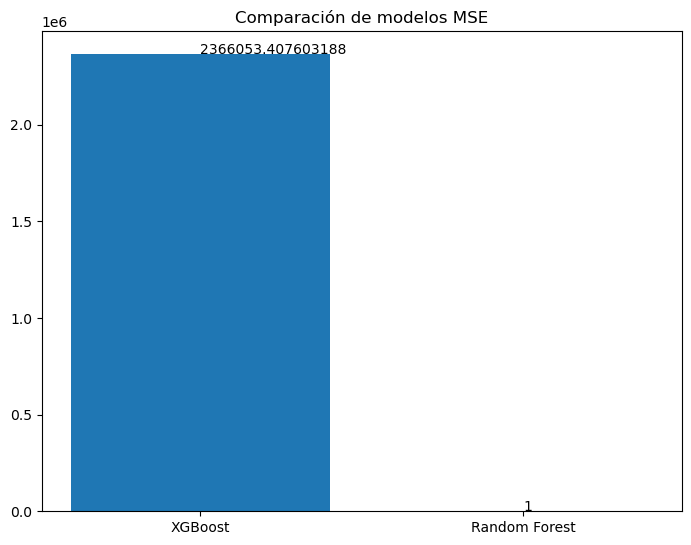

In [55]:
# Celda 8
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos MSE")
ejeX = ['XGBoost', 'Random Forest']
ejeY = [MSEXGB,1 ]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

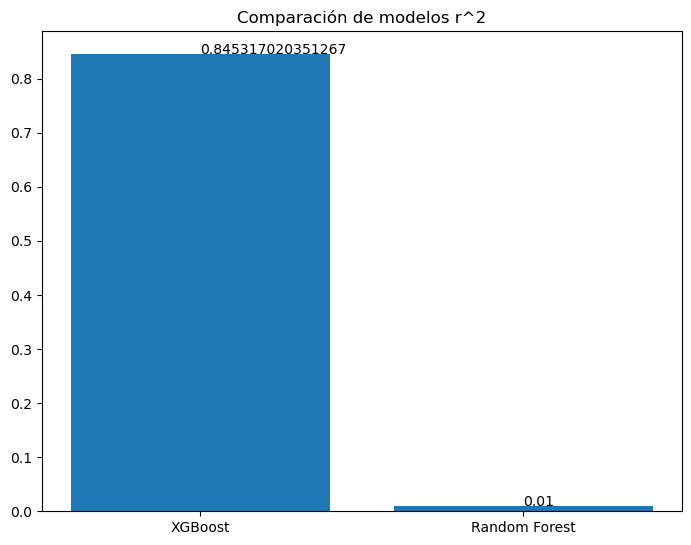

In [53]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos r^2")
ejeX = ['XGBoost', 'Random Forest']
ejeY = [r2XGB, 0.01 ]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

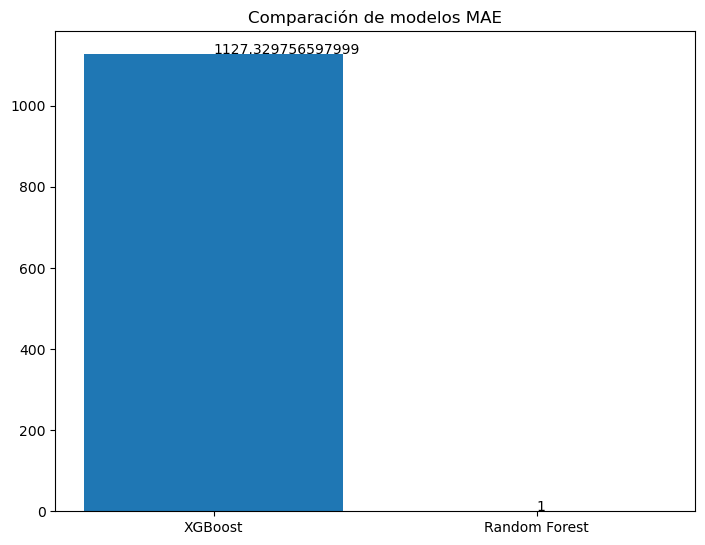

In [54]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos MAE")
ejeX = ['XGBoost', 'Random Forest']
ejeY = [MAEXGB, 1 ]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()